In [1]:
from mu2etools import *
from mu2etools import wideband
hep.style.use('ATLAS')  # or ATLAS/LHCb2
import hist
from hist import Hist

In [2]:
file_cor = uproot.open('root://fndcadoor.fnal.gov:1094/mu2e/scratch/users/oksuzian/sim.mu2e.CosmicDSStopsCORSIKA.MDC2020ab.root:/HitDumper/nt')
file_cry = uproot.open('root://fndcadoor.fnal.gov:1094/mu2e/scratch/users/oksuzian/sim.mu2e.CosmicDSStopsCRY_1000files.010622.root:/HitDumper/nt')

In [3]:
CORSIKA_LTIME = 1868
CRY_LTIME = 1266

In [4]:
arr_cor = file_cor["hits"].array(library="ak")
arr_cry = file_cry["hits"].array(library="ak")
arr_cry['isCRY'] = True
arr_cor['isCRY'] = False
arr_cor['ltime'] = CORSIKA_LTIME
arr_cry['ltime'] = CRY_LTIME

ar = ak.concatenate([arr_cry, arr_cor])

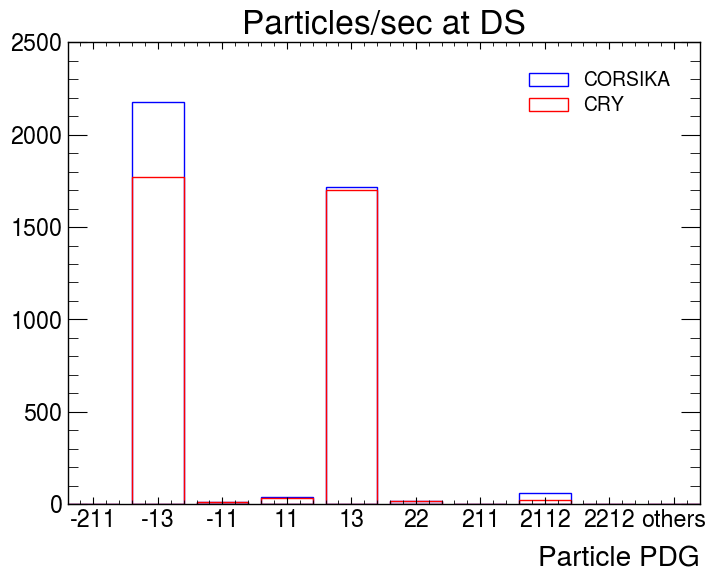

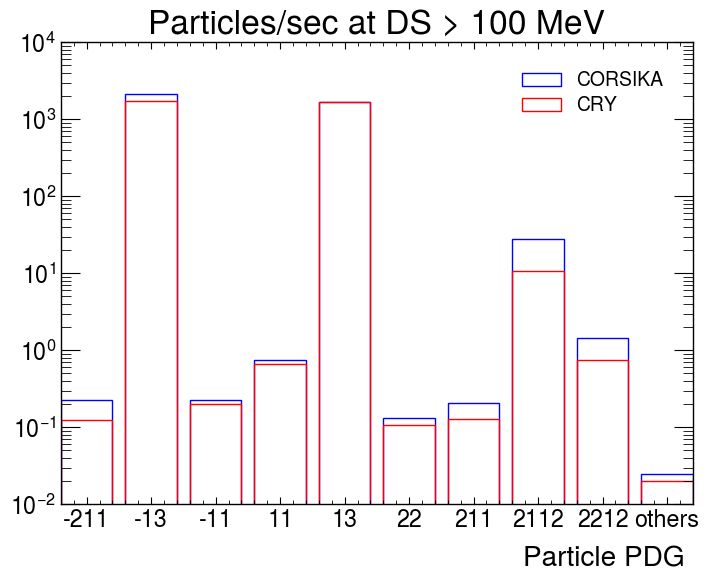

In [5]:
def plot_species(ar, color, label):
    unique_pdgIds, counts = np.unique(ar['pdgId'].to_numpy(), return_counts=True)
    # Identify entries with counts below the threshold
    low_stats_mask = counts < 100
    # Combine low-frequency entries into 'others'
    others_count = np.sum(counts[low_stats_mask])
    others_label = 'others'
    # Filter out low-frequency entries from the data
    filtered_counts = counts[~low_stats_mask]
    filtered_labels = unique_pdgIds[~low_stats_mask]
    # Add the 'others' entry
    filtered_counts = np.append(filtered_counts, others_count)/ar['ltime'][0]
    filtered_labels = np.append(filtered_labels, others_label)    
    # Plot the pie chart
    plt.bar(filtered_labels, filtered_counts, fill=False, edgecolor=color, label=label);
    
plot_species(arr_cor, color='blue', label='CORSIKA')
plot_species(arr_cry, color='red', label='CRY')
plt.legend();
plt.title('Particles/sec at DS')
plt.xlabel('Particle PDG')

plt.figure()
plot_species(arr_cor[arr_cor['ek']>100], color='blue', label='CORSIKA')
plot_species(arr_cry[arr_cry['ek']>100], color='red', label='CRY')
plt.legend();
plt.yscale('log')
plt.title('Particles/sec at DS > 100 MeV')
plt.xlabel('Particle PDG ');


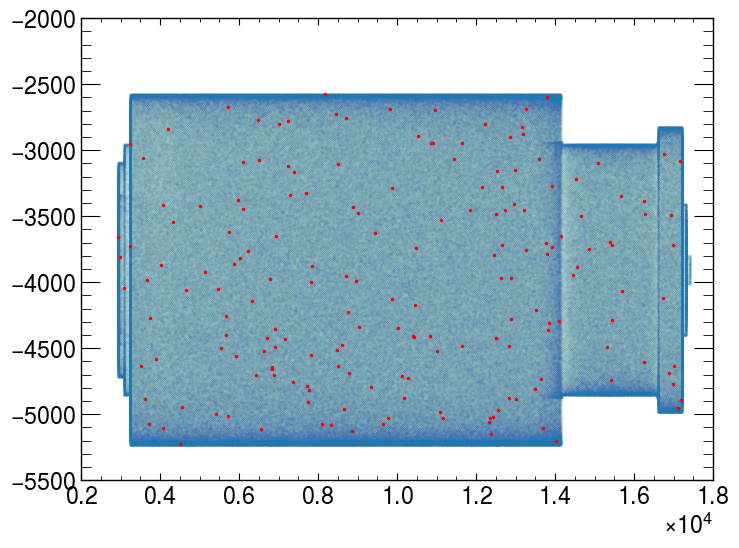

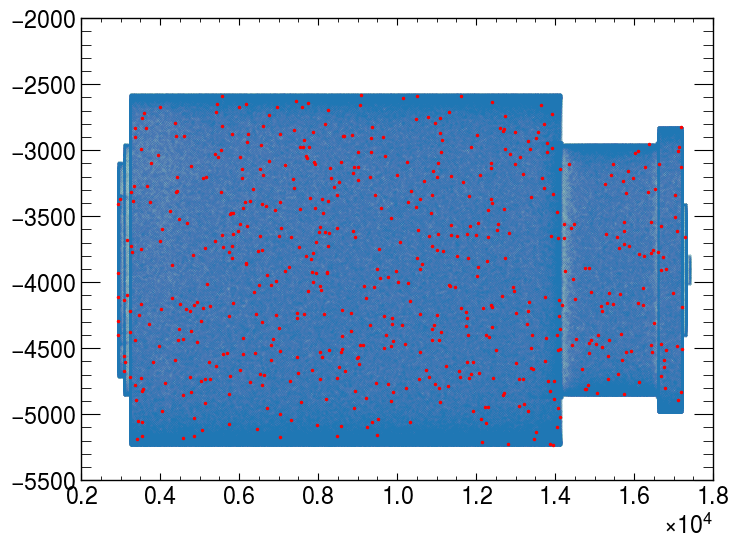

In [6]:
cut=ar['isCRY']
plt.plot(ar[cut]['z'], ar[cut]['x'], '.', markersize=0.01);
cut = (ar['isCRY']) & (ar['pdgId'] == 2112) & (ar['ek'] > 1000)
plt.plot(ar[cut]['z'], ar[cut]['x'], 'r.', markersize=3);

plt.figure()
cut=~ar['isCRY']
plt.plot(ar[cut]['z'], ar[cut]['x'], '.', markersize=0.01);
cut = (~ar['isCRY']) & (ar['pdgId'] == 2112) & (ar['ek'] > 1000)
plt.plot(ar[cut]['z'], ar[cut]['x'], 'r.', markersize=3);

In [7]:
# Define the cut conditions
condition_ek = ar['ek'] > 1000
condition_muons = ar['pdgId'] == 13
condition_neutrons = ar['pdgId'] == 2112

# Cut categories
cut_categories = [condition_muons,
                  condition_neutrons,
                  condition_ek & condition_muons, 
                  condition_ek & condition_neutrons]

In [8]:
# Create histograms
axis1 = hist.axis.IntCategory(label='Gens', name='gen', categories=[0, 1])
axis2 = hist.axis.StrCategory(label='Cuts', name='cut', categories=["Muons", "Neutrons", "Fast Muons", "Fast Neutrons"])

h_InitZ = Hist(hist.new.Reg(100, -50000, 50000, name="InitZ"), axis1, axis2)
h_InitX = Hist(hist.new.Reg(100, -50000, 50000, name="InitX"), axis1, axis2)
h_X = Hist(hist.new.Reg(100, -6000, -2000, name="x"), axis1, axis2)
h_Z = Hist(hist.new.Reg(100, 0, 20000, name="z"), axis1, axis2)
h_E = Hist(hist.new.Reg(100, 0, 20000, name="ek"), axis1, axis2)

histogram_list = [h_InitZ, h_InitX, h_X, h_Z, h_E]

# Iterate over nhits values and fill the histograms
for gen_type in axis1:
    gtype_condition = (ar["isCRY"] == gen_type)
    for idx, cut in enumerate(axis2):
        cut_condition = cut_categories[idx] & gtype_condition
        for histogram in histogram_list:
            var_name = histogram.axes[0].label
            arr_fill = ar[cut_condition][var_name]
            histogram.fill(arr_fill, cut=cut, gen=gen_type, weight=1/ar[gtype_condition]['ltime'][0])

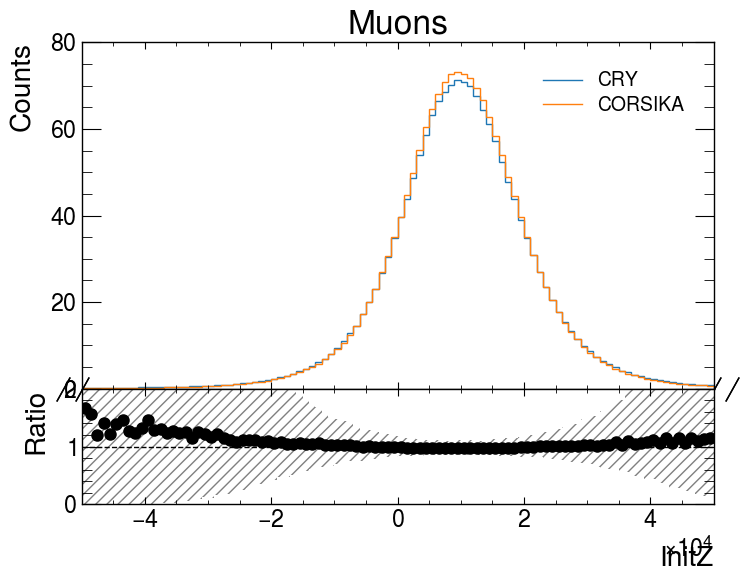

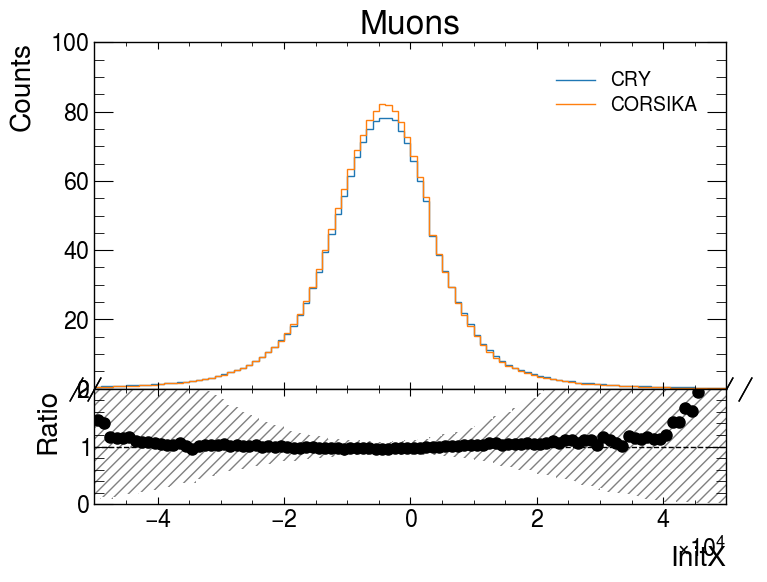

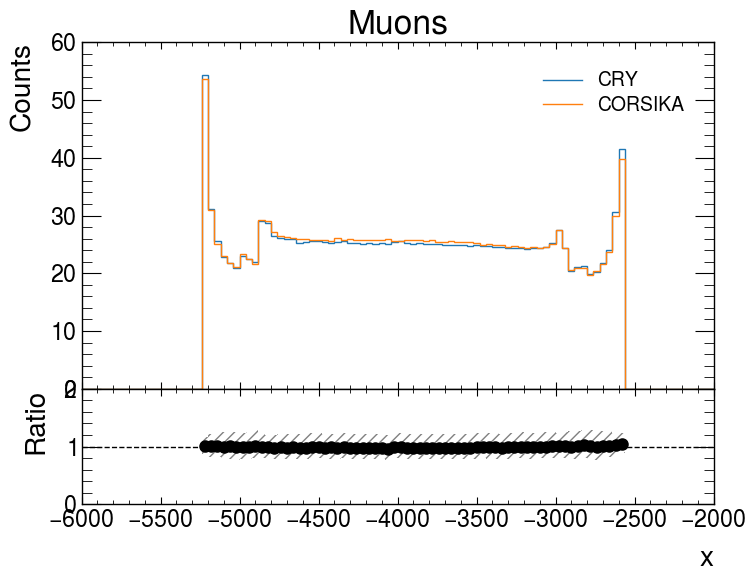

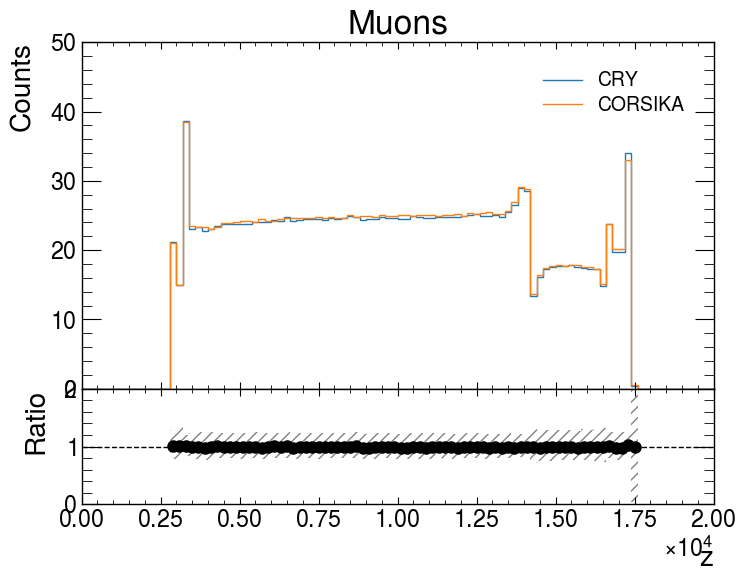

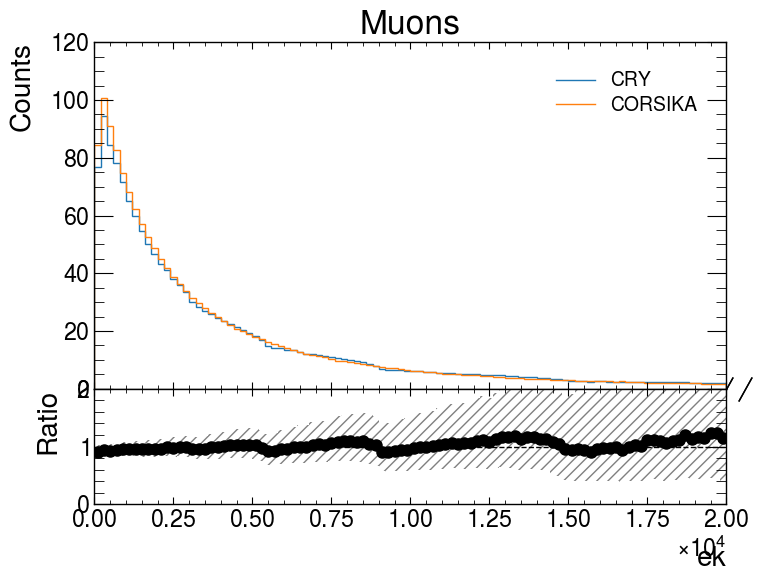

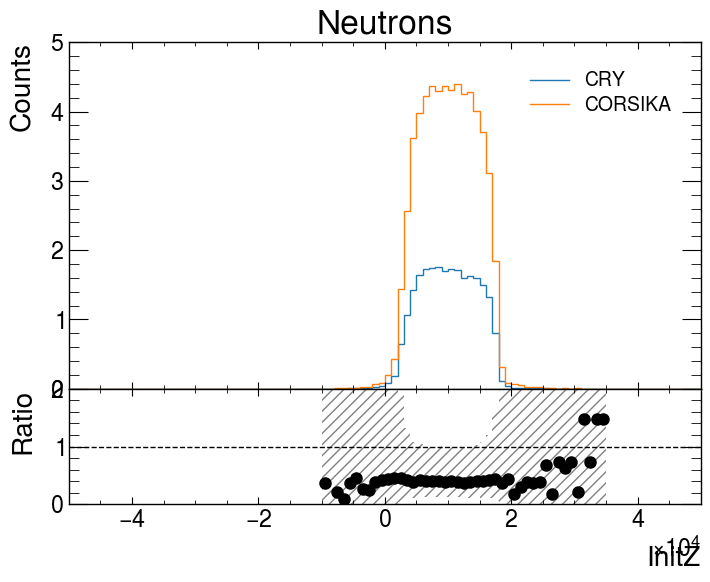

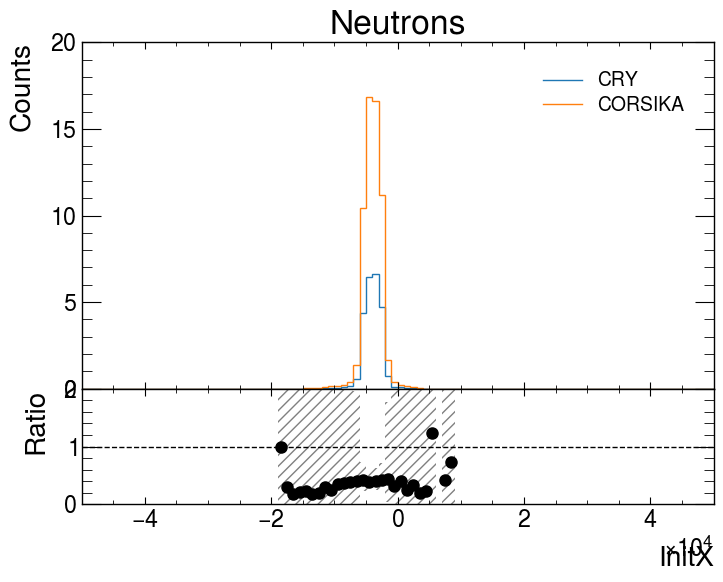

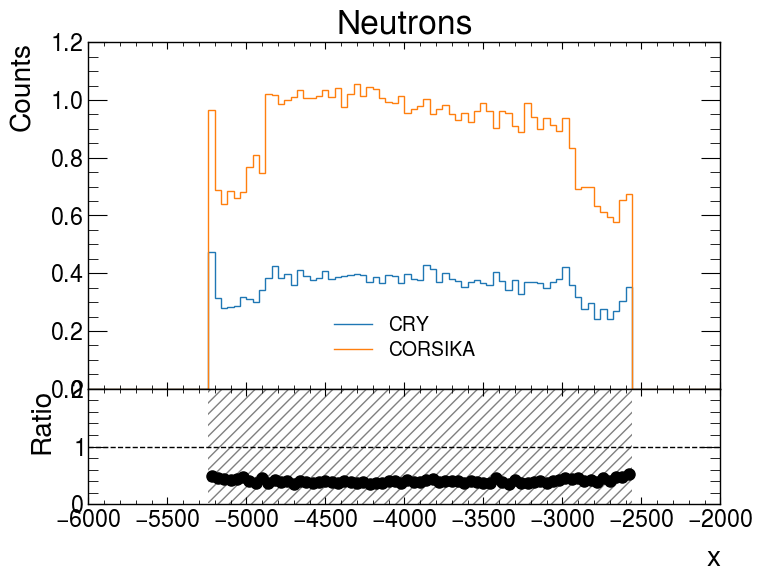

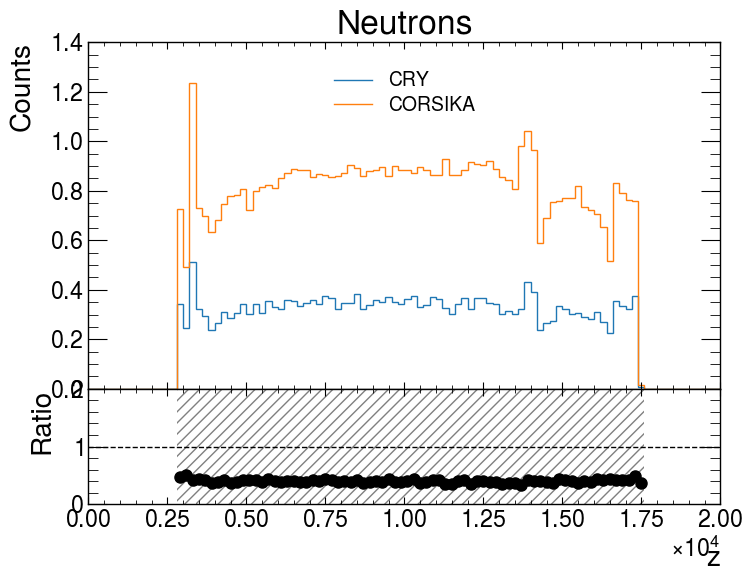

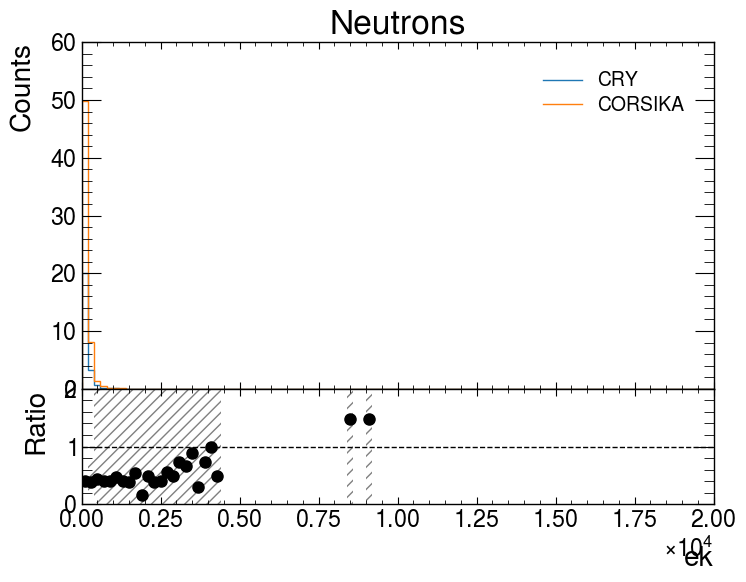

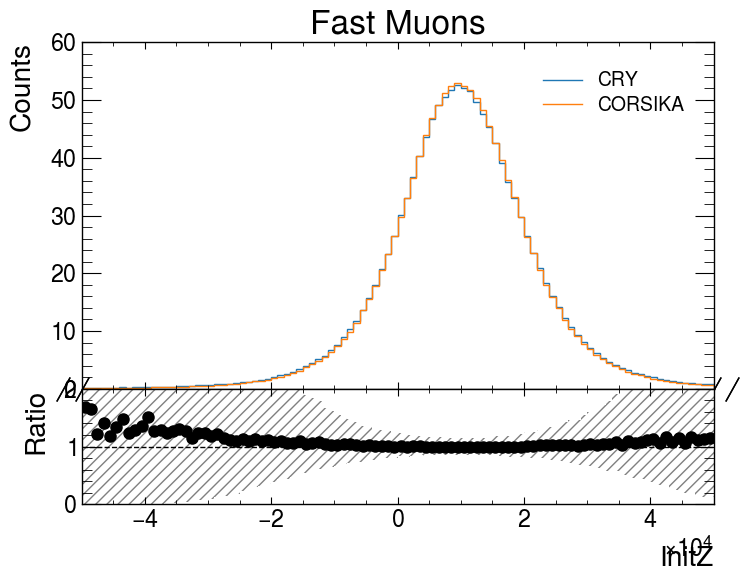

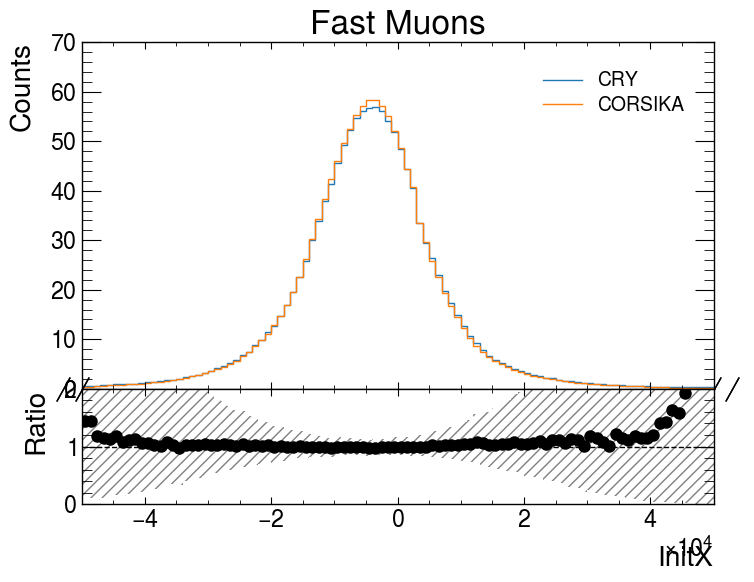

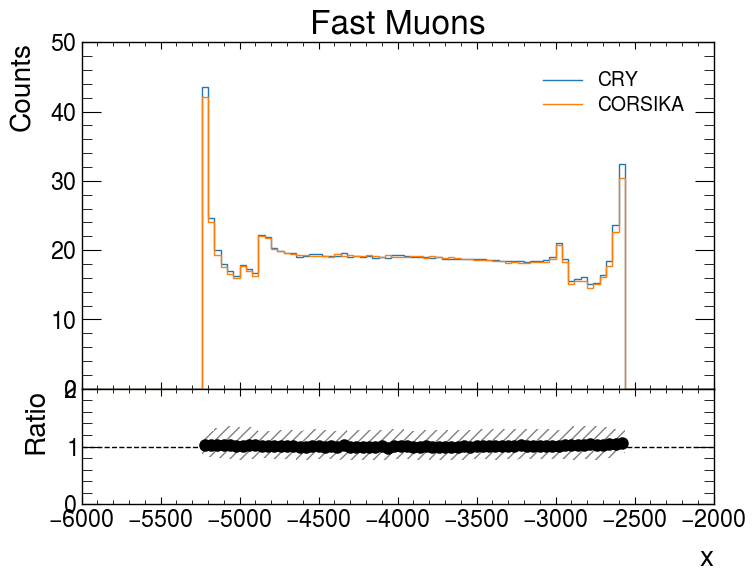

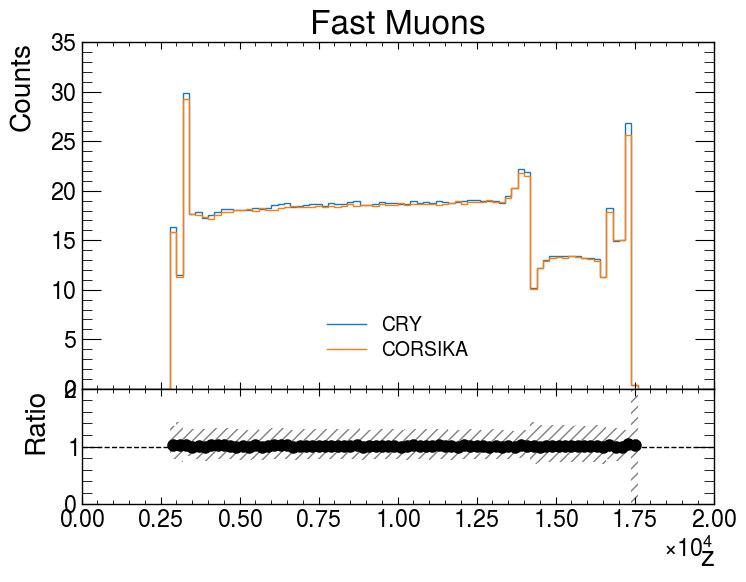

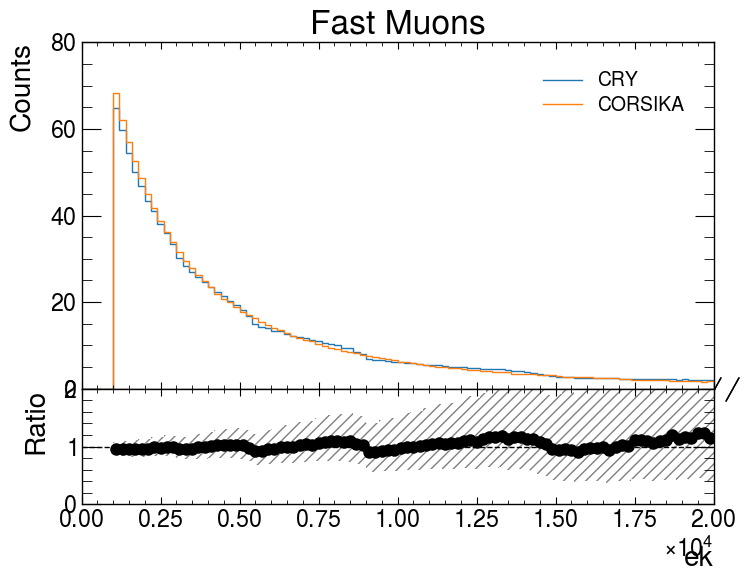

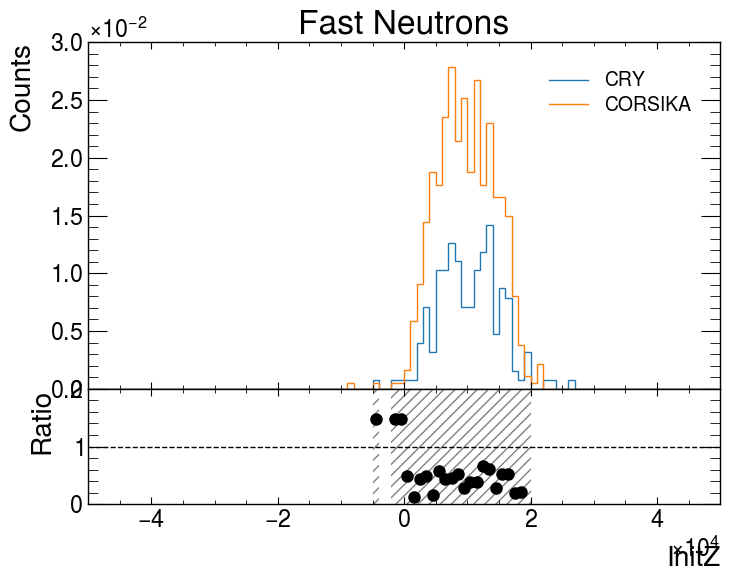

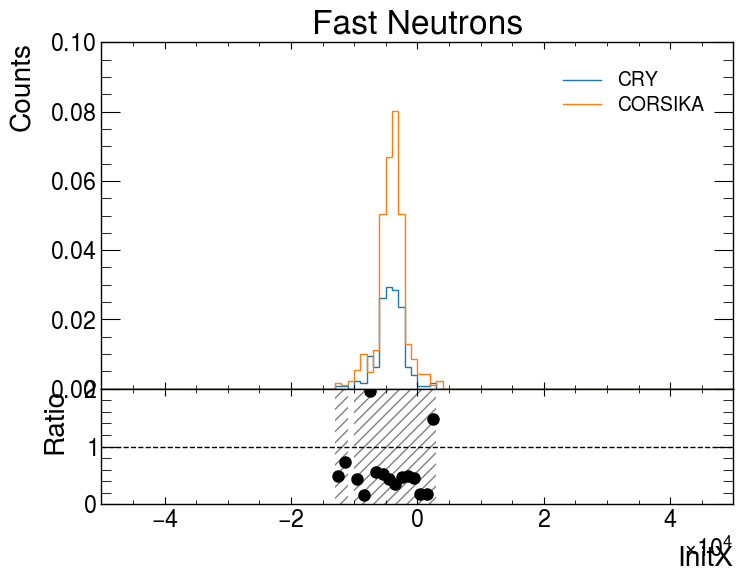

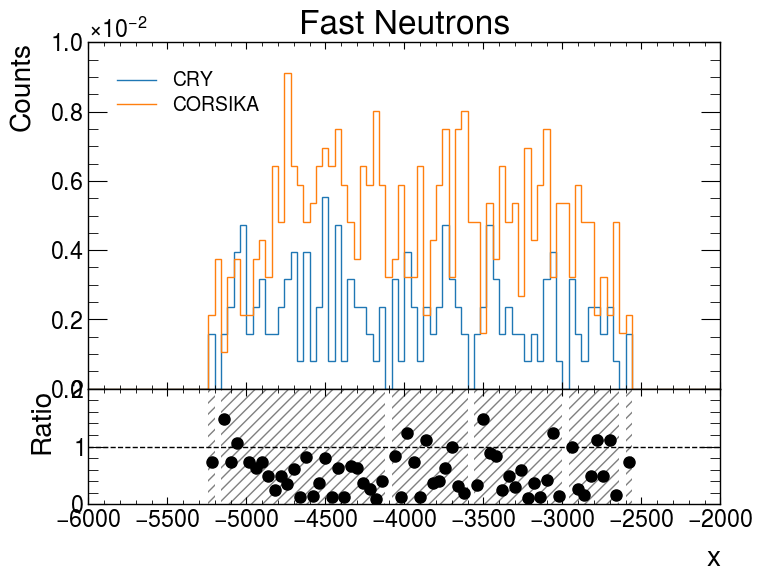

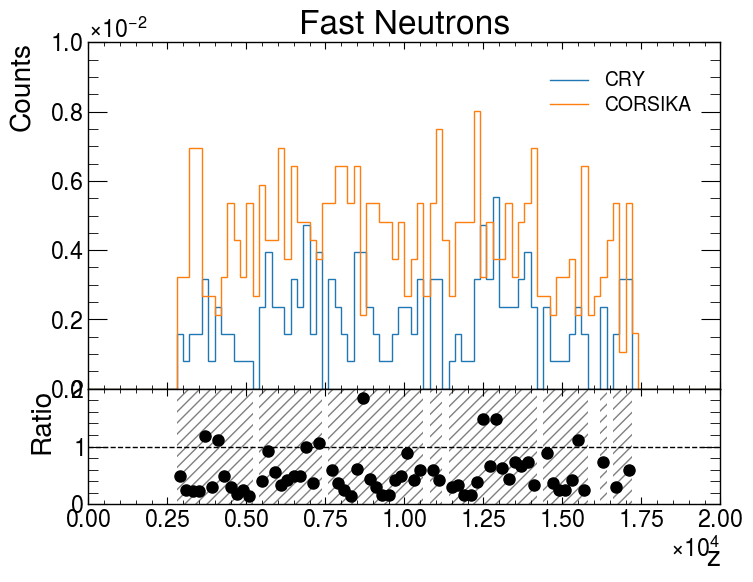

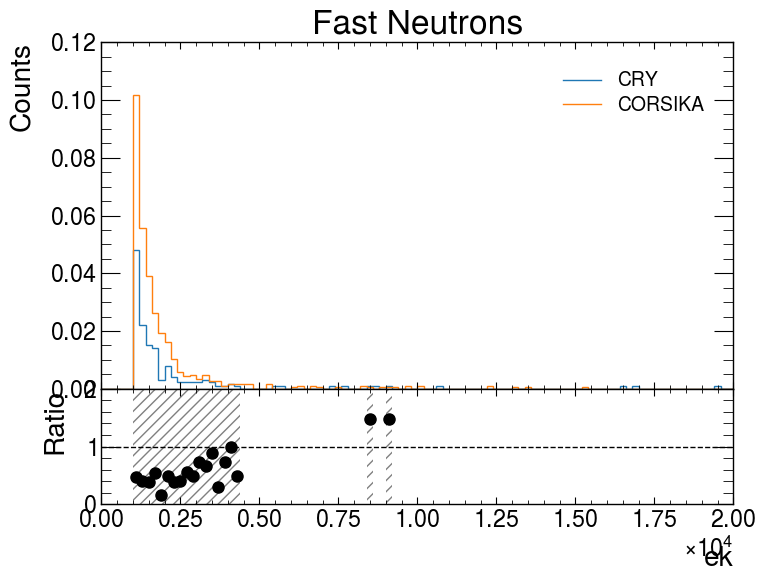

In [9]:
for cut_idx, cut_type in enumerate(axis2):
    for h in histogram_list:
        fig = plt.figure()
        h[:,1,cut_idx].plot_ratio(h[:,0,cut_idx], rp_num_label="CRY", rp_denom_label="CORSIKA", rp_uncert_draw_type='bar');
        fig.get_axes()[0].set_title(cut_type)
        fig.get_axes()[1].set_ylim(0.0, 2) #ratio
